<a href="https://colab.research.google.com/github/zizilnam/Mini_Project_Machine_Learning_Elo_Merchant_Kaggle/blob/main/Elo_project_FullRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Full Regression Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=c01e23bde45d76a54bc73b18395b58797309823ca26e7744916fec56773453cf
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import StackingRegressor
from bayes_opt import BayesianOptimization
from sklearn.linear_model import BayesianRidge

import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from math import sqrt

import joblib
import pickle

from tqdm import tqdm_notebook as tqdm
import time
import gc
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#https://www.kaggle.com/fabiendaniel/elo-world
#Function to load data into pandas and reduce memory usage

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Data Load

In [ ]:
train = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/KDT/모델링 프로젝트/data/train_features_generated.csv', index_col=0))
test = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/KDT/모델링 프로젝트/data/test_features_generated.csv', index_col=0))

Mem. usage decreased to 100.71 Mb (74.7% reduction)
Mem. usage decreased to 61.19 Mb (74.7% reduction)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Columns: 257 entries, card_id to rare_datapoints
dtypes: float16(194), float32(14), int16(15), int8(33), object(1)
memory usage: 100.7+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123623 entries, 0 to 123622
Columns: 255 entries, card_id to merchant_active_months_lag12_12.0_std
dtypes: float16(195), float32(14), int16(12), int8(33), object(1)
memory usage: 61.2+ MB


학습에 필요한 칼럼과 그렇지 않은 칼럼을 나눠줍니다.

In [ ]:
y_train = train['target']
train_card_ids = train['card_id']
train.drop(columns=['card_id', 'target'], inplace=True, axis=1)
X_train = train

In [ ]:
card_ids = test['card_id']
test.drop(columns=['card_id'], inplace=True, axis=1)

In [ ]:
columns = train.columns
columns = columns.drop('rare_datapoints')

## Best Hyper parameter 찾기 작업

입력된 파라미터로 학습후 KFold로 교차 검증하는 함수를 만듭니다.

In [ ]:
def LGB_CV_Bagging(
          max_depth,
          num_leaves,
          min_data_in_leaf,
          feature_fraction,
          bagging_fraction,
          lambda_l1,
          n_estimators,
          colsample_bytree,
          subsample,
          reg_alpha,
          reg_lambda,
          top_rate,
          other_rate,
          min_split_gain,
          min_child_weight
         ):
    
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(X_train.shape[0])

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train[columns], X_train['rare_datapoints'])):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(X_train[columns].iloc[trn_idx],
                               label=y_train.iloc[trn_idx],
                               )
        val_data = lgb.Dataset(X_train[columns].iloc[val_idx],
                               label=y_train.iloc[val_idx],
                               )
    
        param = {
            'task' : 'train',
            'objective' : 'regression',
            'n_estimators':int(n_estimators),
            'num_leaves': int(num_leaves),
            'min_data_in_leaf': int(min_data_in_leaf), 
            'objective':'regression',
            'max_depth': int(max_depth),
            'learning_rate': 0.01,
            "boosting": "gbdt",
            "subsample": subsample,
            'colsample_bytree': colsample_bytree,
            "min_child_weight": min_child_weight,
            "min_split_gain": min_split_gain,
            "reg_alpha": reg_alpha,
            "reg_lambda" : reg_lambda,
            "top_rate": top_rate,
            'other_rate': other_rate,
            "feature_fraction": feature_fraction,
            "bagging_freq": 1,
            "bagging_fraction": bagging_fraction ,
            "bagging_seed": 11,
            "metric": 'rmse',
            "lambda_l1": lambda_l1,
            "verbosity": -1,
            "stratified" : False
        }
    
        clf = lgb.train(param,
                        trn_data,
                        10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds = 200)
        
        oof[val_idx] = clf.predict(X_train[columns].iloc[val_idx],
                                   num_iteration=clf.best_iteration)
        
        del clf, trn_idx, val_idx
        gc.collect()
        
    return -mean_squared_error(oof, y_train)**0.5

In [ ]:
LGB_BO = BayesianOptimization(LGB_CV_Bagging, {
    'max_depth': (4, 10),
    'num_leaves': (5, 130),
    'min_data_in_leaf': (10, 150),
    'feature_fraction': (0.7, 0.99),
    'n_estimators' : (10, 750),
    'bagging_fraction': (0.7, 0.99),
    'lambda_l1': (0, 6),
    'top_rate': (0, 1),
    "other_rate" : (0, 1),
    'subsample': (0, 1),
    'colsample_bytree': (0, 1),
    'reg_alpha': (0, 1),
    "reg_lambda" : (0,10),
    'min_split_gain': (1,50),
    'min_child_weight': (1, 150)
    })

In [ ]:
start_time = time.time()
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=30, acq='ei', xi=0.0)
print("Time taken", time.time()-start_time)
print('-'*130)
print('Final Results')
print('Maximum  value: %f' % LGB_BO.max['target'])
print('Best  parameters: ', LGB_BO.max['params'])

|   iter    |  target   | baggin... | colsam... | featur... | lambda_l1 | max_depth | min_ch... | min_da... | min_sp... | n_esti... | num_le... | other_... | reg_alpha | reg_la... | subsample | top_rate  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.50619	valid_1's rmse: 3.71251
Did not meet early stopping. Best iteration is:
[509]	training's rmse: 3.50406	valid_1's rmse: 3.7126
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.5086	valid_1's rmse: 3.68844
Did not meet early stopping. Best iteration is:
[509]	training's rmse: 3.50684	valid_1's rmse: 3.68834
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.50266	valid_1's rmse: 3.71522
Did

1st tuning

Best  parameters:  {'bagging_fraction': 0.8686284977920036, 'feature_fraction': 0.8482092154218599, 'lambda_l1': 4.1639135977176585, 'max_depth': 9.576234490755708, 'min_data_in_leaf': 83.68633283126034, 'n_estimators': 660.3399358967316, 'num_leaves': 90.81288796818258}



Final Results11600

Maximum  value: -3.700202
Best  parameters:  {'bagging_fraction': 0.9148169692127184, 'colsample_bytree': 0.6298140131171257, 'feature_fraction': 0.8443429059267908, 'lambda_l1': 5.856986534932158, 'max_depth': 9.784578342839247, 'min_child_weight': 87.83424542183701, 'min_data_in_leaf': 91.81371886805323, 'min_split_gain': 18.27574916027187, 'n_estimators': 562.2834742348521, 'num_leaves': 129.74985890479212, 'other_rate': 0.35029742612279446, 'reg_alpha': 0.9803638943393569, 'reg_lambda': 8.145900153921245, 'subsample': 0.4885657717026137, 'top_rate': 0.01689801630741028}

best hyperparameter를 입력해 예측하고 평가해봅니다.

In [ ]:
# Sleep for a few seconds.
import time
time.sleep(2)

# Play an audio beep. Any audio URL will do.
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
cd/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1

/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1


In [ ]:
params = {
          'task': 'train',
          'boosting': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'learning_rate': 0.01,
          "bagging_freq": 1,
          "bagging_seed": 11,
          "verbosity": -1,
          "stratified" : False,
          'bagging_fraction': 0.9148169692127184,
          'colsample_bytree': 0.6298140131171257,
          'feature_fraction': 0.8443429059267908,
          'lambda_l1': 5.856986534932158,
          'max_depth': 10,
          'min_child_weight': 87.83424542183701,
          'min_data_in_leaf': 92,
          'min_split_gain': 18.27574916027187,
          'n_estimators': 562,
          'num_leaves': 130,
          'other_rate': 0.35029742612279446,
          'reg_alpha': 0.9803638943393569,
          'reg_lambda': 8.145900153921245,
          'subsample': 0.4885657717026137,
          'top_rate': 0.01689801630741028
          }

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
oof = np.zeros(X_train.shape[0])
test_predictions = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train[columns], X_train['rare_datapoints'])):
  print("fold n°{}".format(fold_))
  trn_data = lgb.Dataset(X_train[columns].iloc[trn_idx],
                          label=y_train.iloc[trn_idx],
                          )
  val_data = lgb.Dataset(X_train[columns].iloc[val_idx],
                          label=y_train.iloc[val_idx],
                          )

  clf = lgb.train(params,
                  trn_data,
                  10000,
                  valid_sets = [trn_data, val_data],
                  verbose_eval=500,
                  early_stopping_rounds = 200,
                  )

  oof[val_idx] = clf.predict(X_train[columns].iloc[val_idx],
                              num_iteration=clf.best_iteration)
  
  #save the model for final pipeline
  filename = 'Goss_StratifiedKFold_Model_' + str(fold_+1) + '.pkl'
  with open(filename, 'wb') as f:
    pickle.dump(clf, f)

  #Test predictions  
  test_predictions += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits

fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.37494	valid_1's rmse: 3.68233
Did not meet early stopping. Best iteration is:
[562]	training's rmse: 3.35471	valid_1's rmse: 3.68181
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.37436	valid_1's rmse: 3.69956
Did not meet early stopping. Best iteration is:
[562]	training's rmse: 3.35479	valid_1's rmse: 3.69937
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.36992	valid_1's rmse: 3.70225
Did not meet early stopping. Best iteration is:
[562]	training's rmse: 3.34672	valid_1's rmse: 3.70226
fold n°3
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.378	valid_1's rmse: 3.69242
Did not meet early stopping. Best iteration is:
[562]	training's rmse: 3.35527	valid_1's rmse: 3.69196
fold n°4
Training until validation scores don't improve for 200 rounds.
[500]	trai

In [ ]:
cv_rmse = sqrt(mean_squared_error(y_train, oof))
print("CV RMSE: {:2.5f}".format(cv_rmse))

CV RMSE: 3.69974


## Model 학습 후 평가

다시 LGBM으로 모델 학습 후 KFold로 교차 검증합니다.

In [ ]:
feature_importance_df = pd.DataFrame()


folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=5)
oof_2 = np.zeros(X_train.shape[0])
test_predictions_2 = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train[columns], y_train.values)):
  print("fold n°{}".format(fold_))
  trn_data = lgb.Dataset(X_train[columns].iloc[trn_idx],
                          label=y_train.iloc[trn_idx],
                          )
  val_data = lgb.Dataset(X_train[columns].iloc[val_idx],
                          label=y_train.iloc[val_idx],
                          )
  params ={
          'task': 'train',
          'boosting': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'learning_rate': 0.01,
          "bagging_freq": 1,
          "bagging_seed": 11,
          "verbosity": -1,
          "stratified" : False,
          'bagging_fraction': 0.9148169692127184,
          'colsample_bytree': 0.6298140131171257,
          'feature_fraction': 0.8443429059267908,
          'lambda_l1': 5.856986534932158,
          'max_depth': 10,
          'min_child_weight': 87.83424542183701,
          'min_data_in_leaf': 92,
          'min_split_gain': 18.27574916027187,
          'n_estimators': 562,
          'num_leaves': 130,
          'other_rate': 0.35029742612279446,
          'reg_alpha': 0.9803638943393569,
          'reg_lambda': 8.145900153921245,
          'subsample': 0.4885657717026137,
          'top_rate': 0.01689801630741028
                }

  clf = lgb.train(params,
                  trn_data,
                  10000,
                  valid_sets = [trn_data, val_data],
                  verbose_eval=500,
                  early_stopping_rounds = 200,
                  )

  oof_2[val_idx] = clf.predict(X_train[columns].iloc[val_idx],
                              num_iteration=clf.best_iteration)

  test_predictions_2 += clf.predict(test, num_iteration=clf.best_iteration) / (5*2)

  fold_importance_df = pd.DataFrame()
  fold_importance_df["feature"] = columns
  fold_importance_df["importance"] = np.log1p(clf.feature_importance(importance_type='gain', iteration=clf.best_iteration))
  fold_importance_df["fold"] = fold_ + 1
  feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.39917	valid_1's rmse: 3.59968
Did not meet early stopping. Best iteration is:
[562]	training's rmse: 3.3801	valid_1's rmse: 3.59947
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.35705	valid_1's rmse: 3.73065
Did not meet early stopping. Best iteration is:
[562]	training's rmse: 3.33464	valid_1's rmse: 3.73073
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.38028	valid_1's rmse: 3.71081
Did not meet early stopping. Best iteration is:
[562]	training's rmse: 3.35876	valid_1's rmse: 3.71054
fold n°3
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.37972	valid_1's rmse: 3.64369
Did not meet early stopping. Best iteration is:
[562]	training's rmse: 3.35883	valid_1's rmse: 3.64308
fold n°4
Training until validation scores don't improve for 200 rounds.
[500]	tra

In [ ]:
cv_rmse = sqrt(mean_squared_error(y_train, oof_2))
print("CV RMSE: {:2.5f}".format(cv_rmse))

CV RMSE: 3.70033


In [ ]:
train_preds = pd.DataFrame()
test_preds = pd.DataFrame()

train_preds['card_id'] = train_card_ids
train_preds['full_regression_prediction'] = oof_2
test_preds['card_id'] = card_ids
test_preds['full_regression_prediction'] = test_predictions_2

In [ ]:
with open('train_predictions_full_regression.pkl', 'wb') as f:
  pickle.dump(train_preds,f)

with open('test_predictions_full_regression.pkl', 'wb') as f:
  pickle.dump(test_preds,f)

In [ ]:
train_preds

,card_id,full_regression_prediction
0,C_ID_92a2005557,-0.221721
1,C_ID_3d0044924f,-0.330804
2,C_ID_d639edf6cd,0.081999
3,C_ID_186d6a6901,-0.192981
4,C_ID_cdbd2c0db2,-0.334109
...,...,...
201912,C_ID_963962de2c,0.205108
201913,C_ID_1314773c0b,-0.280603
201914,C_ID_7666735b3d,0.007375
201915,C_ID_73f5a0efd0,-1.473949


## Feature Importance in Full Regression

In [ ]:
def display_importances(feature_importance_df_, num_top_features):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:num_top_features].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(25, 25))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)', fontsize = 25)
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')
    return cols

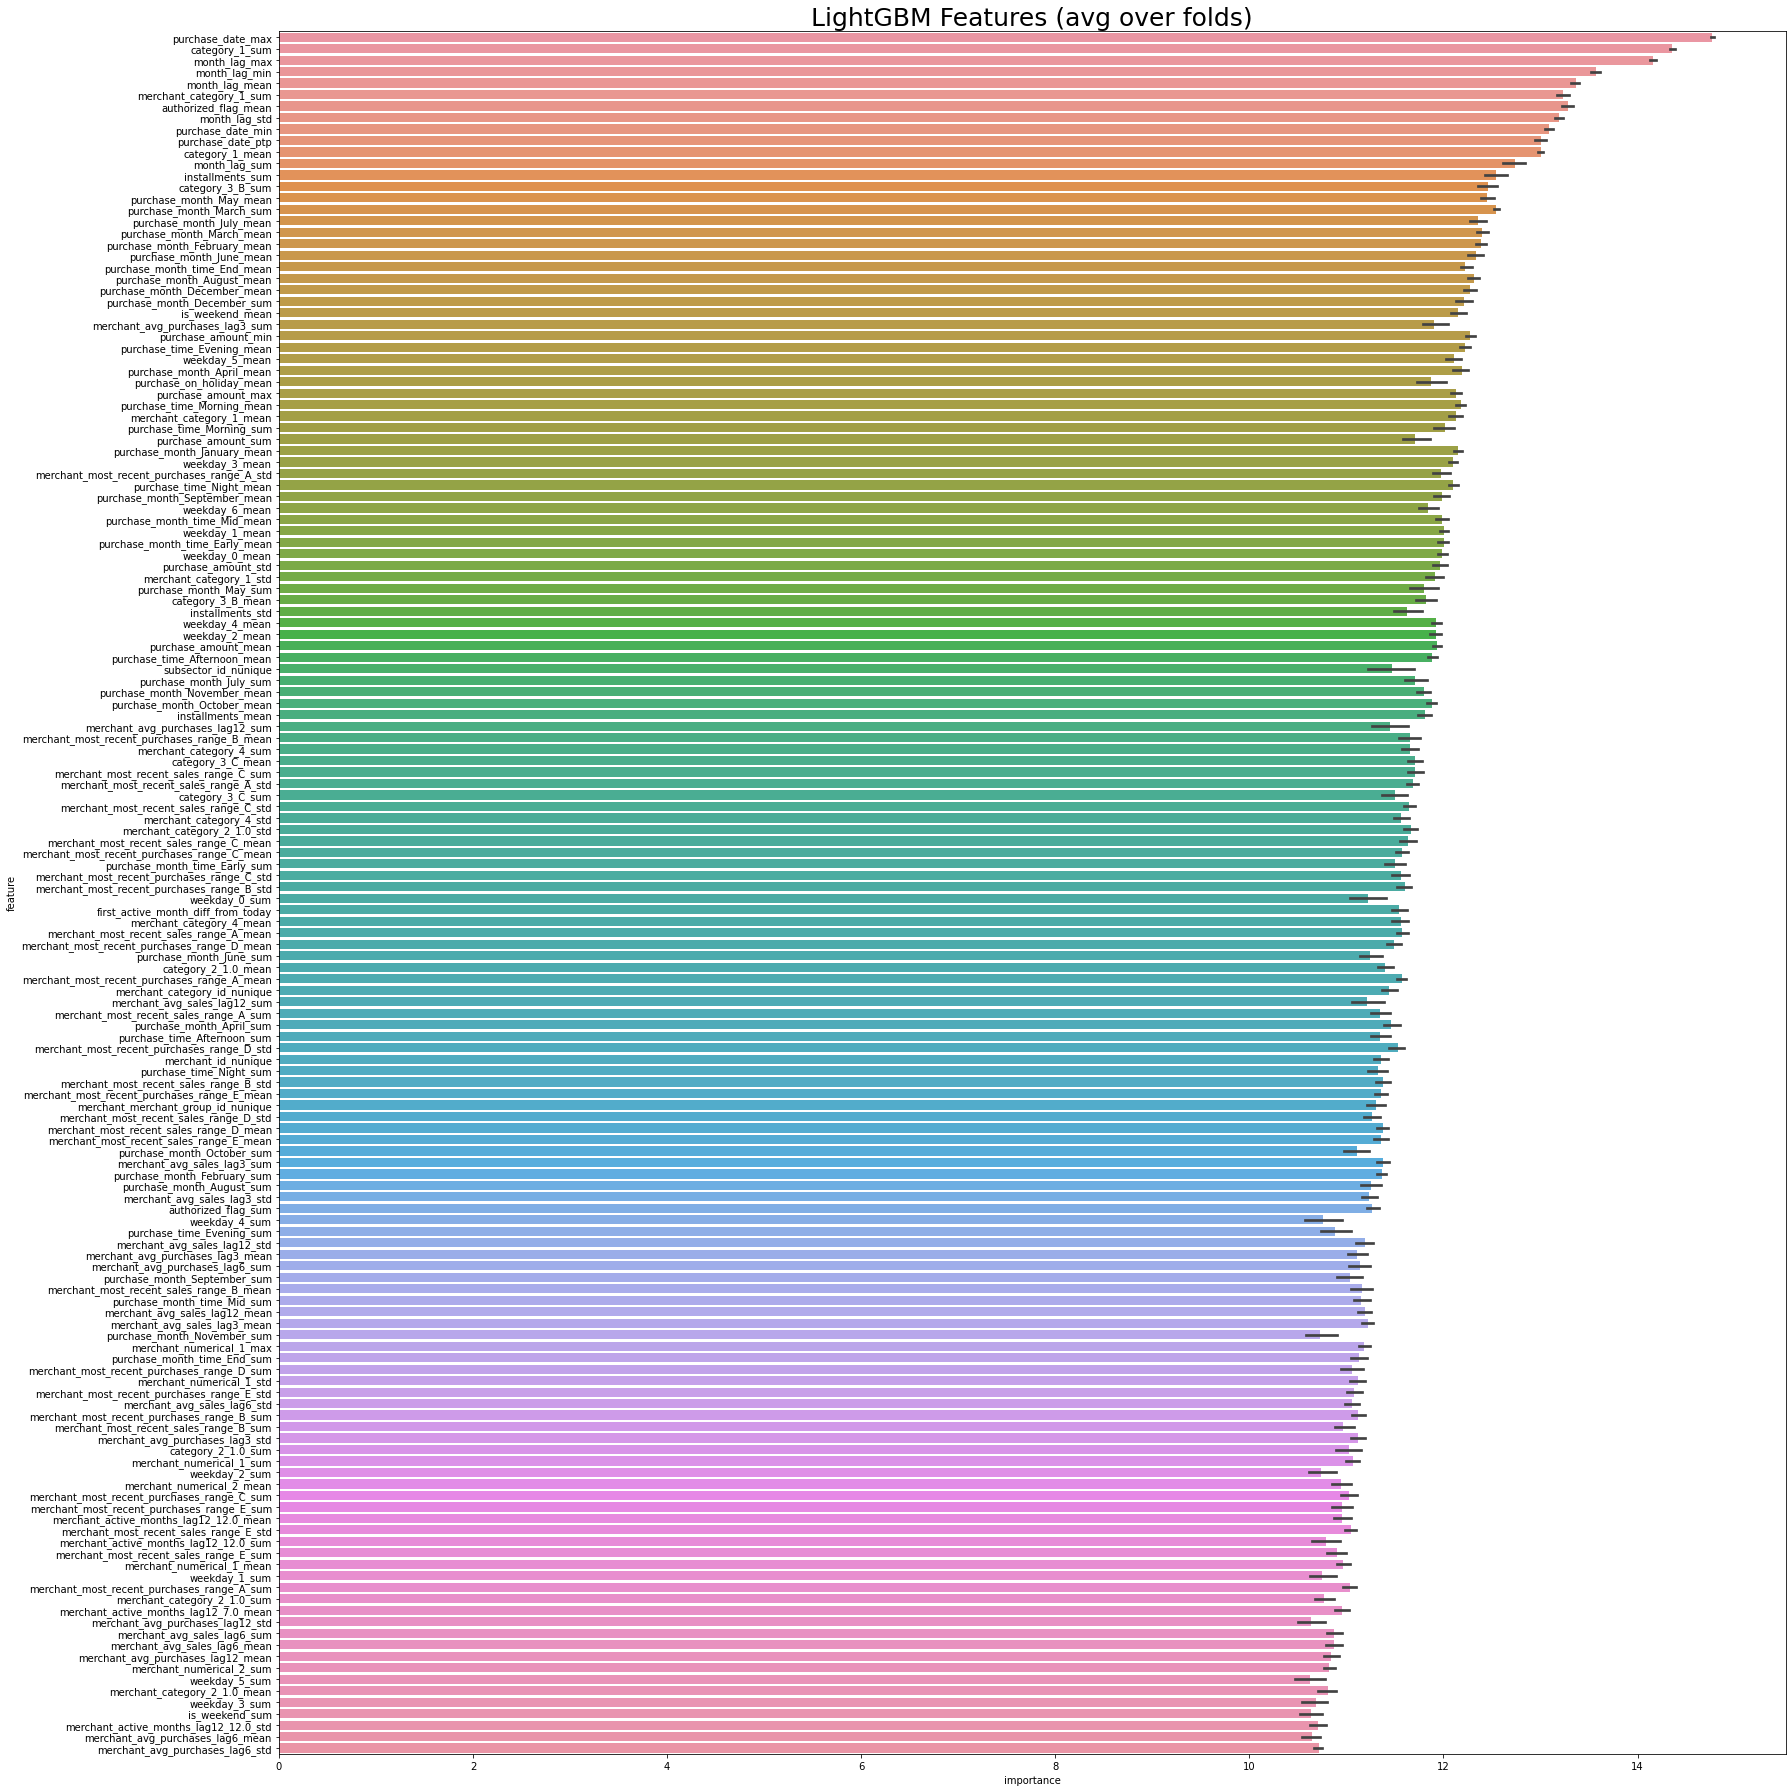

In [ ]:
top_150_features = display_importances(feature_importance_df, 150)
top_200_features = display_importances(feature_importance_df, 200)

In [ ]:
import pickle

with open('top_150_features.pkl', 'wb') as f:
  pickle.dump(top_150_features,f)

with open('top_200_features.pkl', 'wb') as f:
  pickle.dump(top_200_features, f)

NameError: ignored